In this notebook, we will discuss about how to fine-tune a pre-trained LLM using Huggingface ecosystem.

###**What is Fine-tuning?**

Fine-tuning is taking a pre-trained model and training at least one internal model parameter (i.e. weights). In the context of LLMs, what this typically accomplishes is transforming a general-purpose base model (e.g. GPT-3) into a specialized model for a particular use case (e.g. ChatGPT)


The key upside of this approach is that models can achieve better performance while requiring far fewer manually labeled examples compared to models that solely rely on supervised training.


###**Why do we Fine-tune?**

Fine-tuning not only improves the performance of a base model, but a smaller (fine-tuned) model can often outperform larger (more expensive) models on the set of tasks on which it was trained.

* Although most of the LLMs we may interact with these days are not strictly self-supervised models like GPT-3, there are still drawbacks to prompting an existing fine-tuned model for a specific use case. A big one is LLMs have a finite context window. Thus, the model may perform sub-optimally on tasks that require a large knowledge base or domain-specific information.

Fine-tuned models can avoid this issue by “learning” this information during the fine-tuning process. This also precludes the need to jam-pack prompts with additional context and thus can result in lower inference costs.


###There are **3 generic ways one can fine-tune a model**:
* self-supervised,

* supervised,

* and reinforcement learning

###**Self-supervised Learning**

Self-supervised learning consists of training a model based on the inherent structure of the training data. In the context of LLMs, what this typically looks like is given a sequence of words (or tokens, to be more precise), predict the next word (token).

While this is how many pre-trained language models are developed these days, it can also be used for model fine-tuning. A potential use case of this is developing a model that can mimic a person’s writing style given a set of example texts.

###**Supervised Learning**

 Perhaps most popular, way to fine-tune a model is via supervised learning. This involves training a model on ***input-output pairs for a particular task***. An example is instruction tuning, which aims to improve model performance in answering questions or responding to user prompts.

The key step in supervised learning is curating a training dataset. A simple way to do this is to create question-answer pairs and integrate them into a prompt template


###**Reinforcement Learning**

Finally, one can use reinforcement learning (RL) to fine-tune models. RL uses a ***reward model*** to guide the training of the base model. This can take many different forms, but the basic idea is to train the reward model to score language model completions such that they reflect the preferences of human labelers. The reward model can then be combined with a reinforcement learning algorithm (e.g. ***Proximal Policy Optimization (PPO)***) to fine-tune the pre-trained model.

###**3 Options for Parameter Training**

I will focus on three generic options of which to choose on parameter trainings:

###**Retrain all parameters**

* The first option is to train all internal model parameters (called full parameter tuning). While this option is simple (conceptually), it is the most computationally expensive. Additionally, a known issue with full parameter tuning is the phenomenon of catastrophic forgetting. This is where the model “forgets” useful information it “learned” in its initial training.

###**Transfer Learning**

* The big idea with transfer learning (TL) is to preserve the useful representations/features the model has learned from past training when applying the model to a new task. This generally consists of dropping “the head” of a neural network (NN) and replacing it with a new one (e.g. adding new layers with randomized weights).

* While leaving the majority of parameters untouched mitigates the huge computational cost of training an LLM, TL may not necessarily resolve the problem of catastrophic forgetting. To better handle both of these issues, we can turn to a different set of approaches.


###**Parameter Efficient Fine-tuning (PEFT)**

PEFT involves augmenting a base model with a relatively small number of trainable parameters. The key result of this is a fine-tuning methodology that demonstrates comparable performance to full parameter tuning at a tiny fraction of the computational and storage cost.

PEFT encapsulates a family of techniques, one of which is the popular LoRA (Low-Rank Adaptation) method. The basic idea behind LoRA is to pick a subset of layers in an existing model and modify their weights according to the following equation.

$$
h(x) = W_0x + \Delta Wx = W_0x + BAx
$$
Where,
$$
W_0, \Delta W \in \mathbb{R}^{d \times k},
$$
$$
B \in \mathbb{R}^{d \times r},
$$
$$
A \in \mathbb{R}^{r \times k}.
$$


Where h() = a hidden layer that will be tuned, x = the input to h(), W₀ = the original weight matrix for the h, and ΔW = a matrix of trainable parameters injected into h. ΔW is decomposed according to ΔW=BA, where ΔW is a d by k matrix, B is d by r, and A is r by k. r is the assumed “intrinsic rank” of ΔW.

The key point is the (d * k) weights in W₀ are frozen and, thus, not included in optimization. Instead, the ((d * r) + (r * k)) weights making up matrices B and A are the only ones that are trained.






In [3]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score



In [4]:
#importing the training data
imdb_data=pd.read_csv('/content/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
#To perform EDA
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [12]:
#split the dataset
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


####Text Normalization

In [13]:
import nltk
nltk.download('stopwords')


#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


####Removing html strips and noise text



In [14]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

####Removing special characters

In [15]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)


####Text stemming

In [16]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

####Removing stopwords

In [17]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'some', 'so', 'theirs', 'between', 'these', 'i', 'having', 'any', 'the', 'be', 'until', 'once', 'a', 'don', 'he', 'does', 'm', 'been', 'below', 'themselves', 'or', 'hasn', 'few', 'too', 'shouldn', 'that', 'those', 'just', "weren't", "mustn't", 've', 'had', 'at', 'hers', 'because', 'such', 'out', 'd', 'than', 'further', 'while', 'an', 'which', 'itself', 'then', 'being', 'y', 'but', 'shan', 'before', 'here', 'more', 'against', 'who', 'under', 'she', 'are', 'up', 'own', "should've", 'can', 'ma', 'in', 'very', "isn't", 'her', 'myself', 'o', 'were', 'when', 'on', "you'd", 'didn', 'about', 'me', 're', "you'll", 'himself', 'and', 'most', "needn't", 'they', "didn't", 't', 'needn', 'herself', "you've", 'won', 'ours', 'to', 'do', "mightn't", 'will', "doesn't", 'doing', "won't", 'there', 'other', 'how', 'each', "hasn't", 'was', 'into', 'your', 'after', 'over', 'should', 'where', 'him', 'this', 'his', 'again', 'haven', 'wasn', 'wouldn', 'you', 'our', 'my', 'their', 'have', 'whom', 'no', 'we', 'wi

####Normalized train reviews

In [18]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

####Normalized test reviews

In [19]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

###Bags of words model

It is used to convert text documents to numerical vectors or bag of words.

In [20]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6209089)
BOW_cv_test: (10000, 6209089)


####**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to matrix of tfidf features.

In [21]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


Labeling the sentiment text

In [22]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


Split the sentiment tdata

In [23]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


####Modelling the dataset

Let us build logistic regression model for both bag of words and tfidf features

In [24]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


Logistic regression model performane on test dataset

In [25]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


####Accuracy of the model

In [26]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


####Print the classification report

In [27]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



####Confusion matrix

In [28]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3768 1239]
 [1249 3744]]
[[3663 1344]
 [1156 3837]]


###**Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features**

In [29]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


Model performance on test data

In [30]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


####Accuracy of the model

In [31]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


###Print the classification report

In [32]:
#Classification report for bag of words
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



####Plot the confusion matrix

In [33]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4948   59]
 [4112  881]]
[[5007    0]
 [4888  105]]


Let us see positive and negative words by using WordCloud.

Word cloud for positive review words

<function matplotlib.pyplot.show(close=None, block=None)>

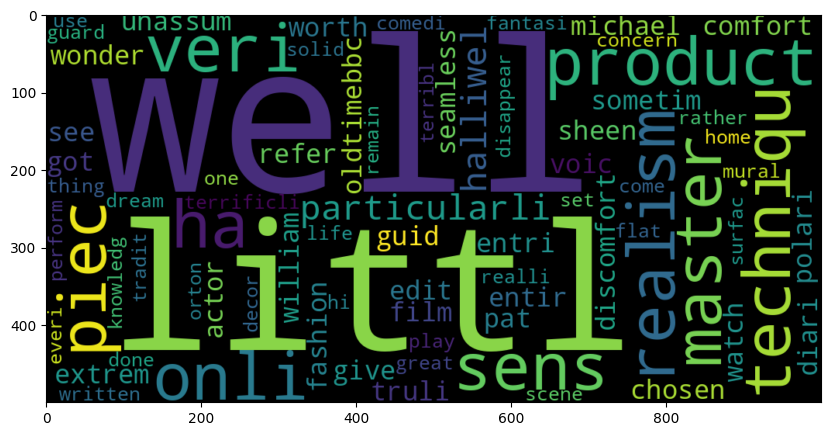

In [34]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

Word cloud for negative review words

<function matplotlib.pyplot.show(close=None, block=None)>

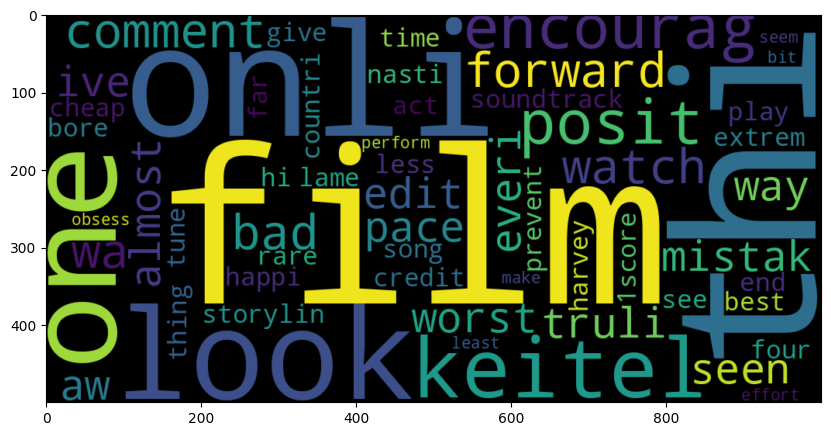

In [35]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

###**Now let's look into the fine-tuning of LLM with LoRA, to check the performance of the data**

In [1]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


* I have started by importing all the useful libraries, transformers, peft, evaluate from huggingface to perform Finetuning of the data


In [2]:
from datasets import load_dataset, DatasetDict, Dataset

In [3]:
pip install peft


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 10.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [4]:
pip install evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [5]:
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

In [ ]:
# # how dataset was generated

# # load imdb data

# imdb_dataset = load_dataset("imdb")

# # define subsample size
# N = 1000
# # generate indexes for random subsample
# rand_idx = np.random.randint(24999, size=N)

# # extract train and test data
# x_train = imdb_dataset['train'][rand_idx]['text']
# y_train = imdb_dataset['train'][rand_idx]['label']

# x_test = imdb_dataset['test'][rand_idx]['text']
# y_test = imdb_dataset['test'][rand_idx]['label']

# # create new dataset
# dataset = DatasetDict({'train':Dataset.from_dict({'label':y_train,'text':x_train}),
#                              'validation':Dataset.from_dict({'label':y_test,'text':x_test})})

Let's load training and validation data from Huggingface datasets library. I have taken a IMDB movie review dataset of 2000 movie reviews (1000 for training and 1000 for validation) with binary labels indicating whether the review is positive (or not).

In [6]:
# load dataset
dataset = load_dataset('shawhin/imdb-truncated')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [7]:
# display % of training data with label=1
np.array(dataset['train']['label']).sum()/len(dataset['train']['label'])

0.5

####Choosing Base model

In [8]:
model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the above step, I have loaded Base model for our demostration. This base model (DistilBertModel) here is a relatively small one, but there are several other (larger) ones that we could have used (e.g. roberta-base, llama2, gpt2)

In [9]:
# display architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

####Preprocess data

we need to preprocess our data so that it can be used for training. This consists of using a tokenizer to convert the text into an integer representation understood by the base model

In [10]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [12]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

To apply the tokenizer to the dataset, I used the .map() method. This takes in a custom function that specifies how the text should be preprocessed. In this case, that function is called tokenize_function().

In addition to translating text to integers, this function truncates integer sequences such that they are no longer than 512 numbers to conform to the base model’s max input length.

In [13]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

At this point, I have created a data collator, which will dynamically pad examples in each batch during training such that they all have the same length

###Evaluation


In [14]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [15]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

We can define how we want to evaluate our fine-tuned model via a custom function. Here, I have defined the compute_metrics() function to compute the model’s accuracy.

####Applying untrained model to text

In [16]:
# define list of examples
text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "This is not worth watching even once.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Negative
Not a fan, don't recommed. - Negative
Better than the first one. - Negative
This is not worth watching even once. - Negative
This one is a pass. - Negative


We can observe, the model performance is equivalent to random guessing. Let’s see how we can improve this with fine-tuning

####Train Model

To use LoRA for fine-tuning, we first need a config file. This sets all the parameters for the LoRA algorithm.

In [17]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [18]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [19]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


We can then create a new version of our model that can be trained via PEFT. Notice that the scale of trainable parameters was reduced by about 100x.


Next, I have defined hyperparameters for model training.

In [20]:
# hyperparameters
lr = 1e-3 #size of optimization step
# number of examples processed per optimziation step
batch_size = 4
# number of times model runs through training data
num_epochs = 8

In [21]:
pip install accelerate -U


In [ ]:
pip install transformers[torch]


In [ ]:
pip install transformers[torch] -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0


In [22]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

Finally, I have created a trainer() object and fine-tune the model

In [1]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

NameError: name 'Trainer' is not defined

###To generate predictions


To see how the model performance has improved, let’s apply it to the same 5 examples from before.

In [ ]:
model.to('mps') # moving to mps for Mac

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("mps") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

The fine-tuned model improved significantly from its prior random guessing, correctly classifying most of them. This aligns with the ~90% accuracy metric we saw during training.

####**Conclusion**


While fine-tuning an existing model requires more computational resources and technical expertise than using one out-of-the-box, (smaller) fine-tuned models can outperform (larger) pre-trained base models for a particular use case, even when employing clever prompt engineering strategies.


####**References:**

https://www.deeplearning.ai/short-courses/finetuning-large-language-models/


https://huggingface.co/blog/peft


https://arxiv.org/abs/2203.02155



####**License:**

Copyright (c) [2024] Anusree Myneni

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

